In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


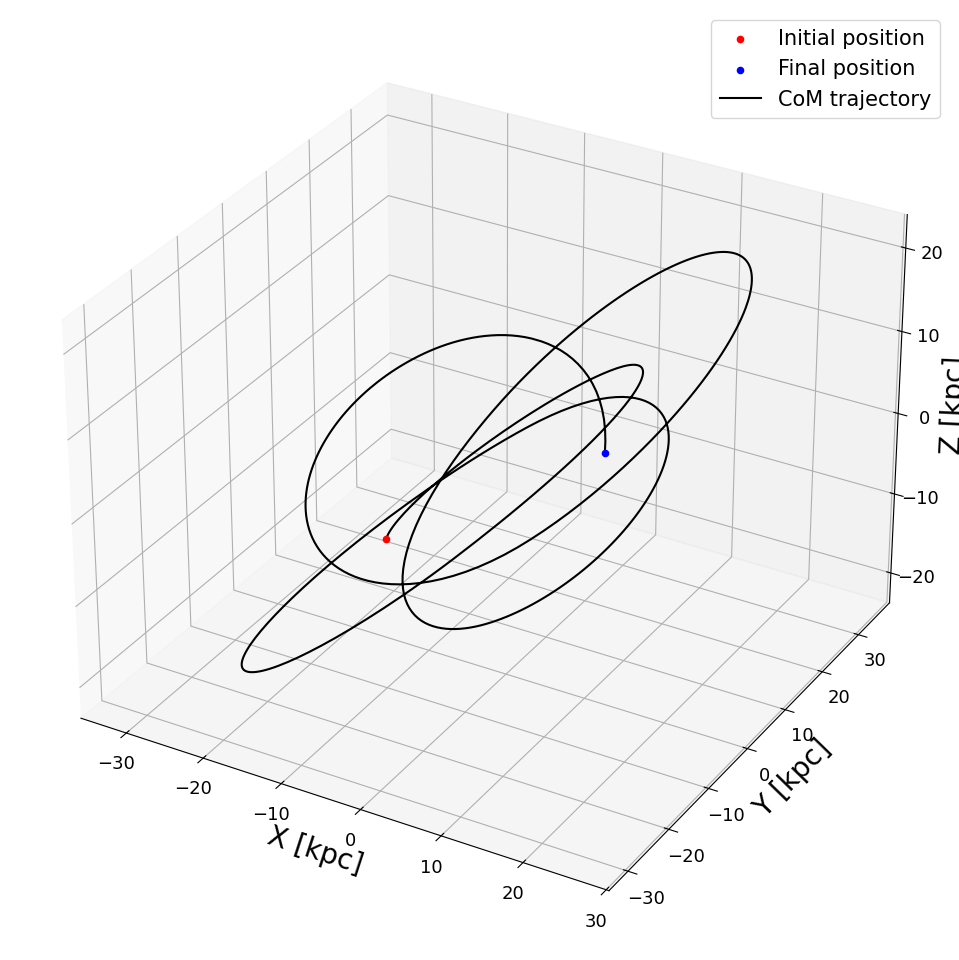

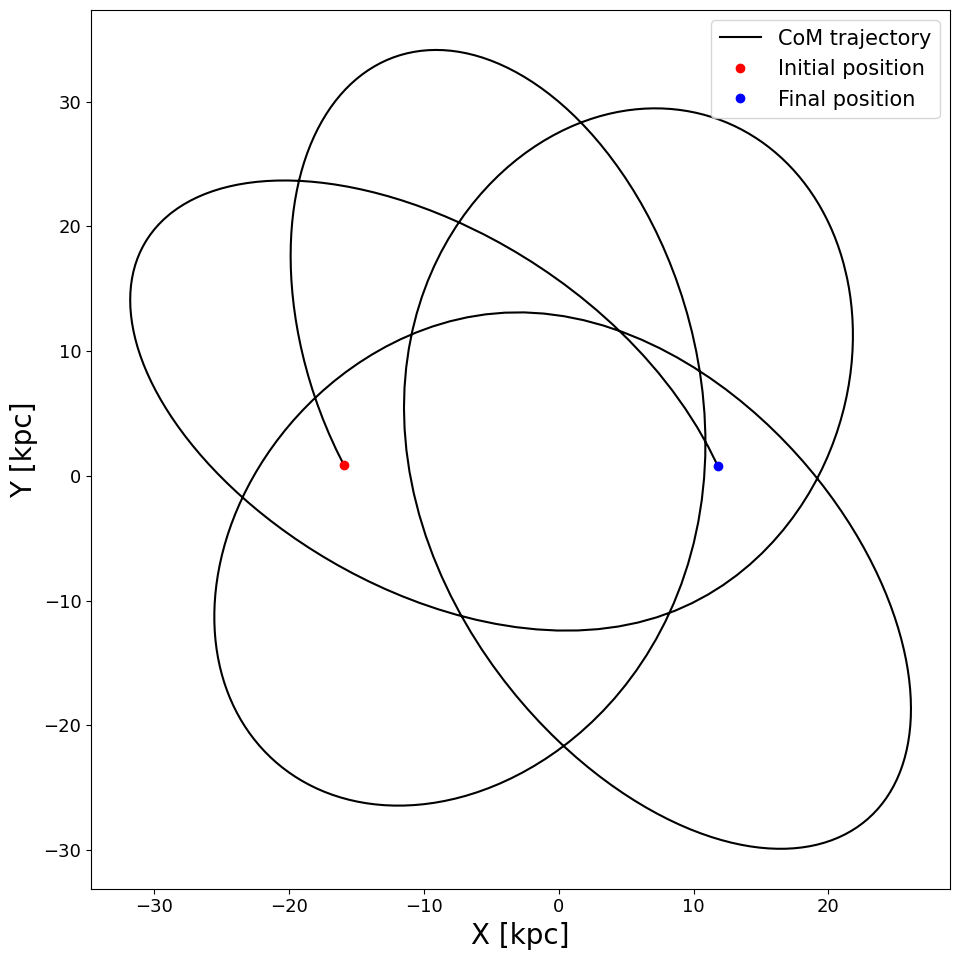

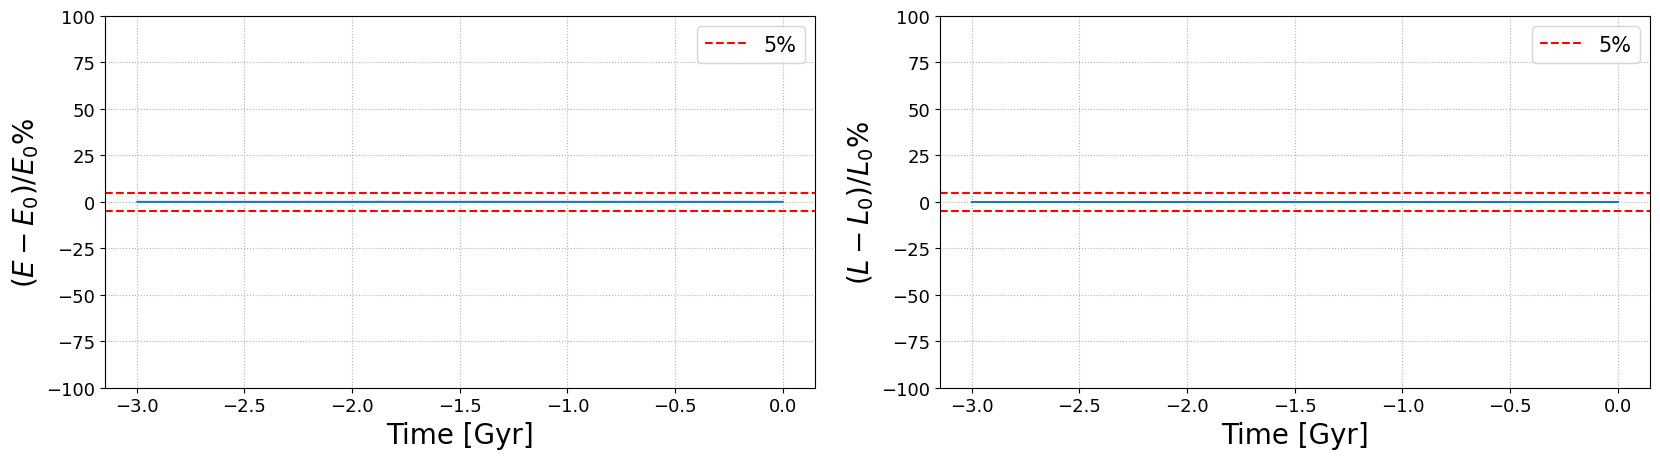

In [3]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [4]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

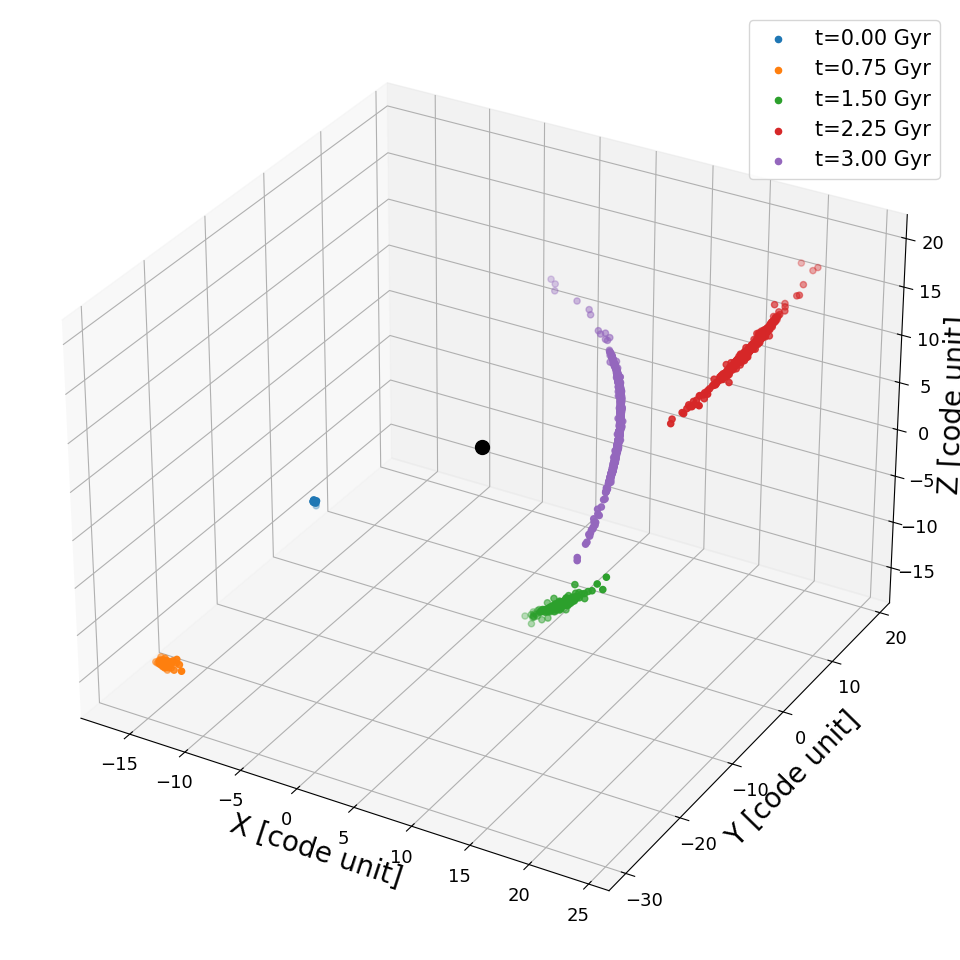

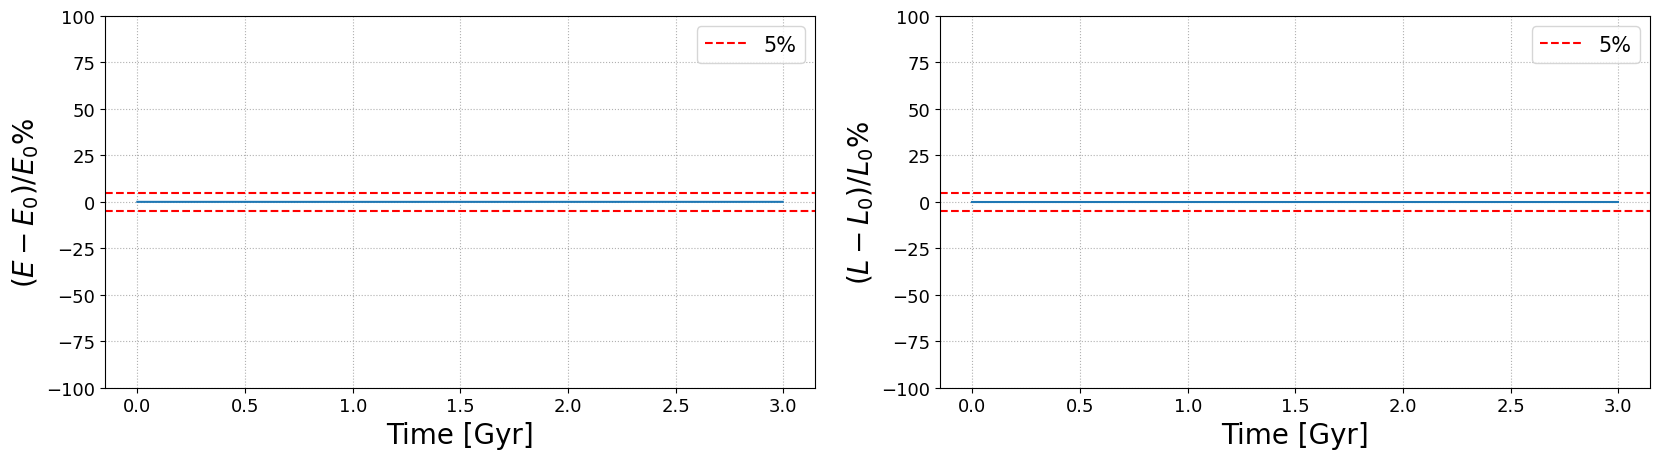

In [5]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


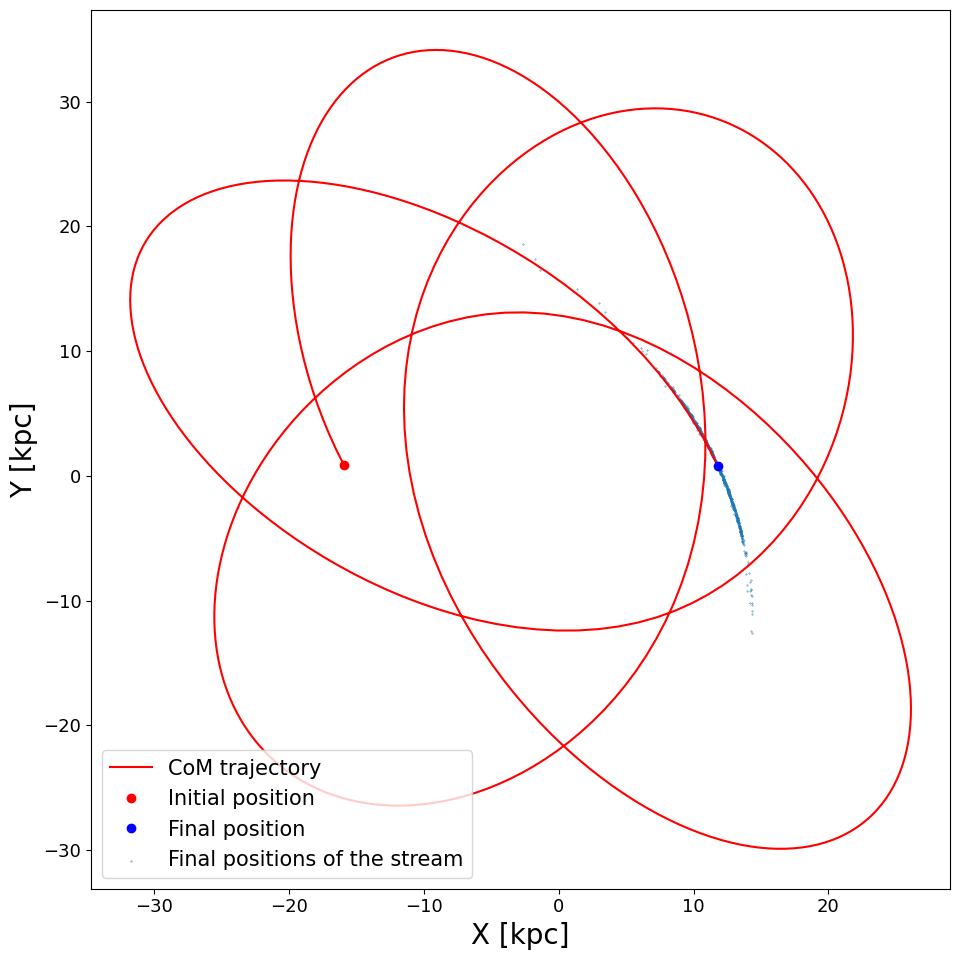

In [6]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

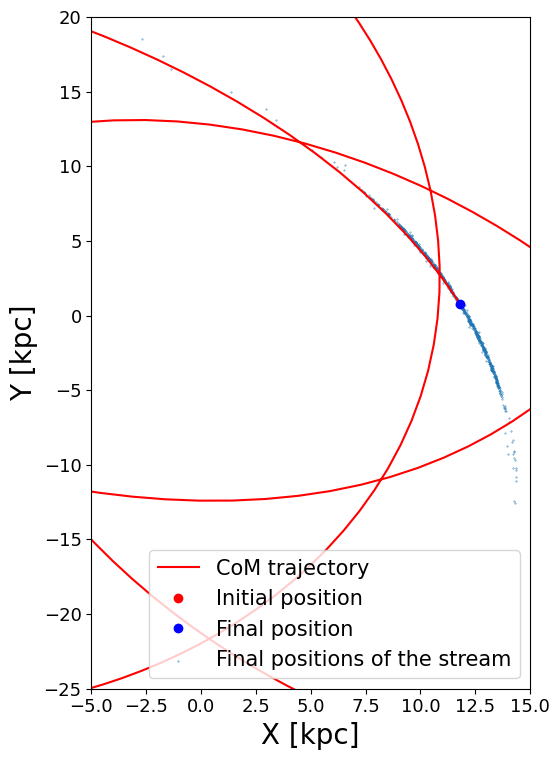

In [7]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [8]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

(-250.0, 250.0)

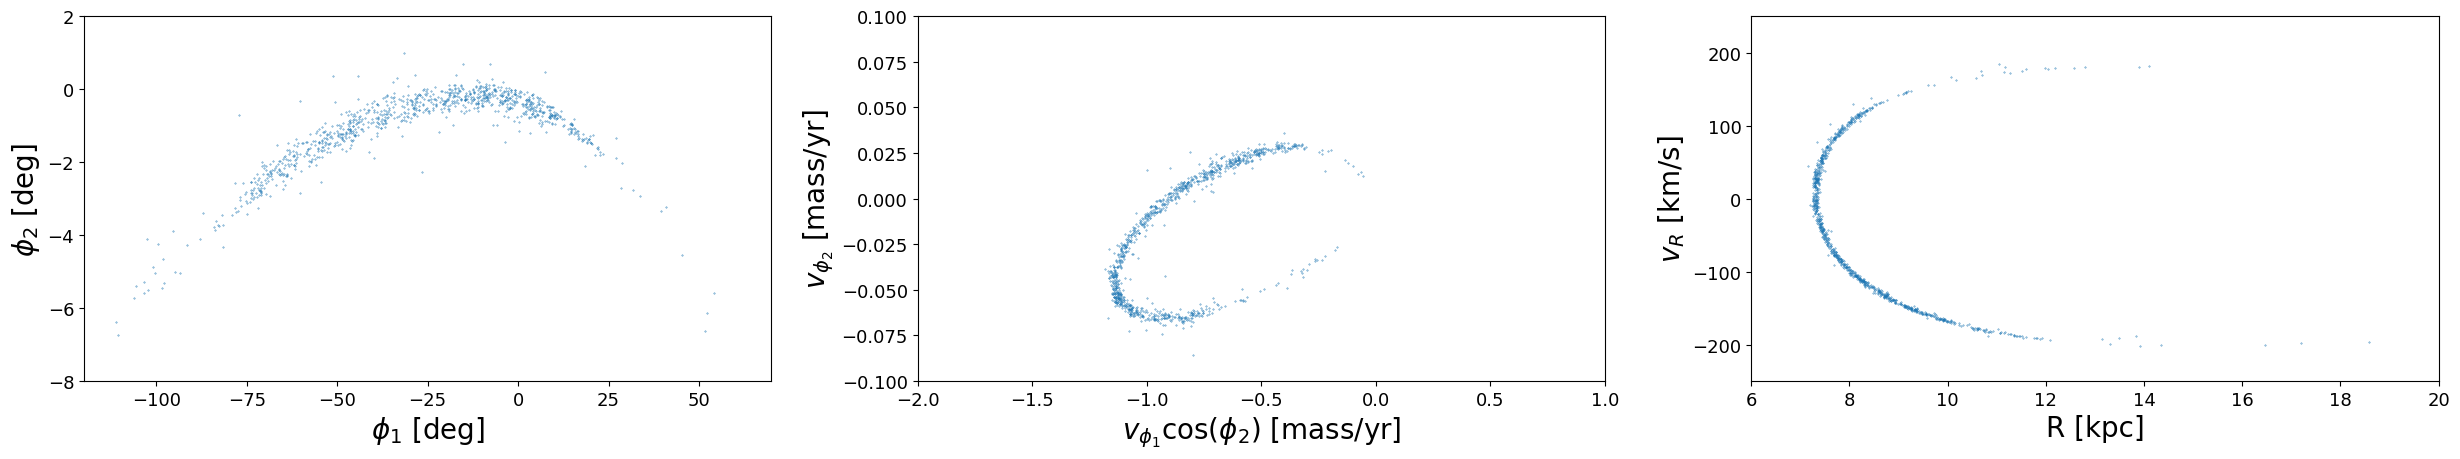

In [9]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_1818257/3570116978.py:21: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_1818257/3570116978.py:31: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_1818257/3570116978.py:40: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


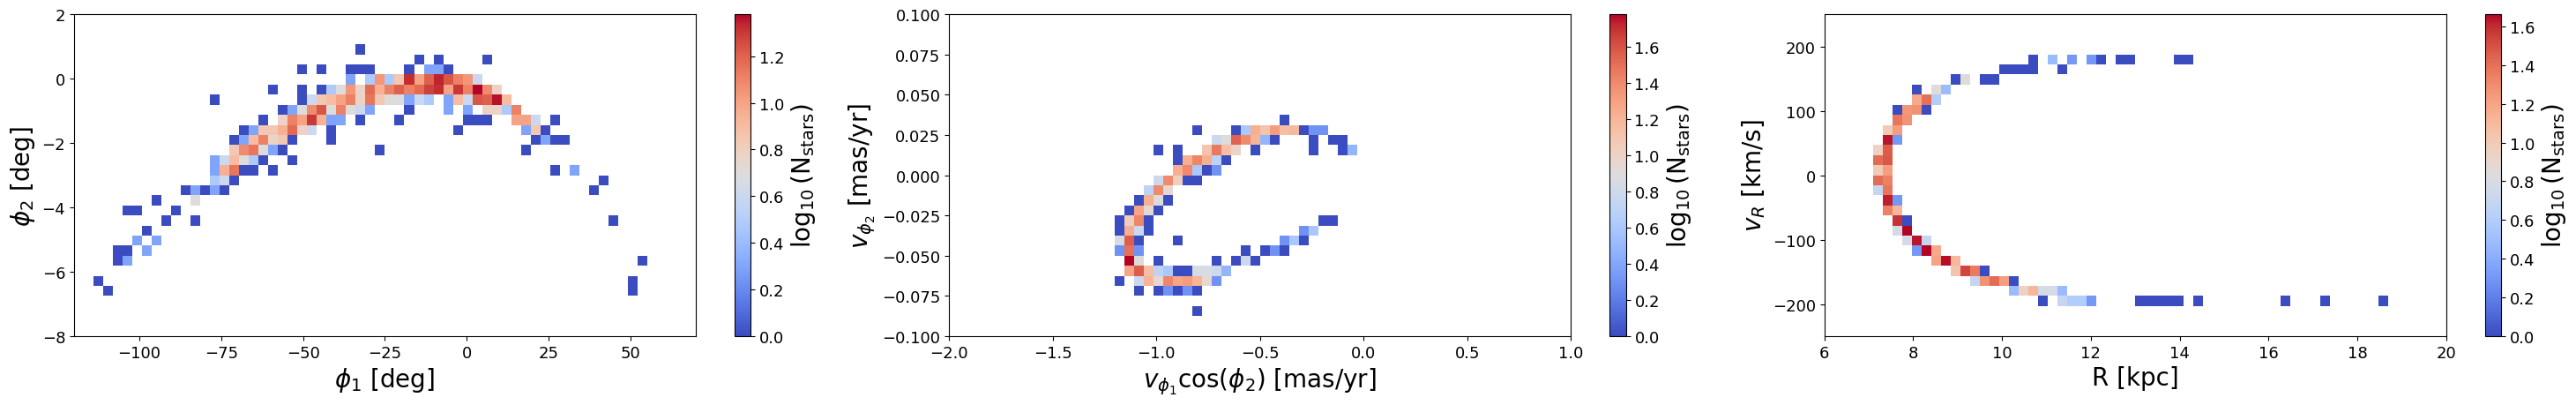

In [10]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

(-8.0, 2.0)

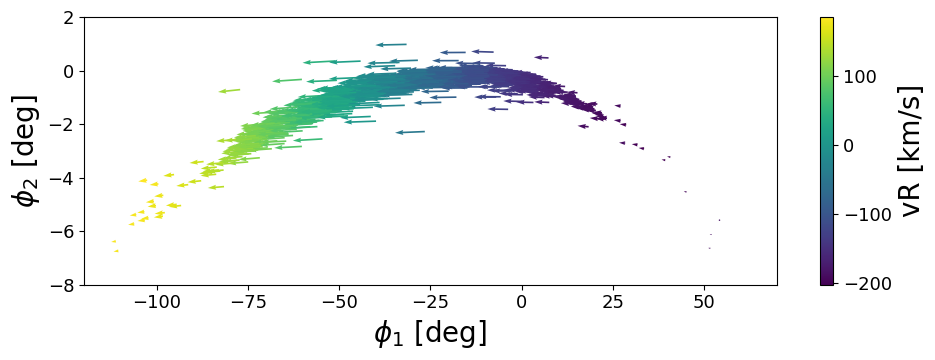

In [11]:
# Plotting the vector field of velocities
fig  = plt.figure(figsize=(10, 4), tight_layout=True)
ax = fig.add_subplot(111)
vectorf_field = ax.quiver(phi1, 
                            phi2,
                            v1_cosphi2/jnp.cos(jnp.deg2rad(phi2)),
                            v2,
                            vR,
                            scale=25,)
plt.colorbar(vectorf_field, ax=ax, label='vR [km/s]')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

In [12]:
stream_target = s

# Normalizing flow

In [ ]:
# Learning the distribution with a NF
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.train import fit_to_data
#steream stacking and standardization
stream = jnp.stack((R, phi1, phi2, vR, v1_cosphi2, v2),).T

#Bernoulli sampling
@jit
def selection_function(stream_star, p, key):
    # Apply selection criteria
    return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

key = random.PRNGKey(42)
keys = random.split(key, stream.shape[0])
p = jnp.ones(shape=(stream.shape[0]))* 0.95
selected_stream = jax.vmap(selection_function, )(stream, p, keys)

@jit 
def background_assignement(key):
    # Generate a random background star position
    return jax.random.uniform(key=key, shape=(6,),
                              minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
                             maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

# Nbackground star contamination
N_background = int(1e6)
#Generate the probability of selectin a background star
background_selected = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
keys = random.split(key, N_background)
selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys, background_selected)

# Combine the selected stream and background stars
stream = jnp.concatenate((selected_stream, selected_background), axis=0)


#add gaussian noise to the stream
noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std

stream_mean = jnp.nanmean(stream, axis=0)
stream_std = jnp.nanstd(stream, axis=0)
stream = (stream - stream_mean) / stream_std  # Standardize the data

# Assign a new out of the observational windows value to the NaN values
# stream = jax.vmap(lambda stream_star: jnp.where(jnp.isnan(stream_star), jnp.ones((6))*100, stream_star))(stream)

#rng
rng = jax.random.key(0)

# create the flow
subkey, rng = jax.random.split(rng)
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(stream.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

#we train only on the non NaN values of the stream
key, subkey = jax.random.split(key)
flow, losses = fit_to_data(subkey, flow, stream[~jnp.isnan(stream)].reshape(-1, 6), learning_rate=1e-3)

  0%|          | 0/100 [00:00<?, ?it/s]2025-06-12 14:15:20.190155: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-12 14:15:20.190213: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-12 14:15:20.190232: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
 19%|█▉        | 19/10

# Using KDE

In [ ]:
# stream = jnp.stack((R, phi1, phi2, vR, v1_cosphi2, v2),)

# kde = jax.scipy.stats.gaussian_kde(stream)

# fig = plt.figure(figsize=(10, 10), tight_layout=True)
# ax = fig.add_subplot(111)
# R_range = jnp.linspace(6, 20, 10)
# phi1_range = jnp.linspace(-120, 70, 10)
# phi2_range = jnp.linspace(-8, 2, 10)
# vR_range = jnp.linspace(-250, 250, 10)
# v1_cosphi2_range = jnp.linspace(-2., 1.0, 10)
# v2_range = jnp.linspace(-0.10, 0.10, 10)
# R_grid, phi1_grid, phi2_grid, vR_grid, v1_cosphi2_grid, v2_grid = jnp.meshgrid(
#     R_range, phi1_range, phi2_range, vR_range, v1_cosphi2_range, v2_range, indexing='ij')
# kde_values = kde(jnp.stack((R_grid.ravel(), phi1_grid.ravel(), phi2_grid.ravel(), 
#                              vR_grid.ravel(), v1_cosphi2_grid.ravel(), v2_grid.ravel()), axis=-1).T)
# kde_values = kde_values.reshape(R_grid.shape)
# im = ax.pcolormesh(phi1_grid[:, :, 0, 0, 0, 0],
#                    phi2_grid[:, :, 0, 0, 0, 0],
#                    kde_values[:, :, 0, 0, 0, 0],
#                    shading='auto',
#                    cmap='coolwarm',
#                    norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='KDE Density')
# ax.set_xlabel("$\phi_1$ [deg]")
# ax.set_ylabel("$\phi_2$ [deg]")


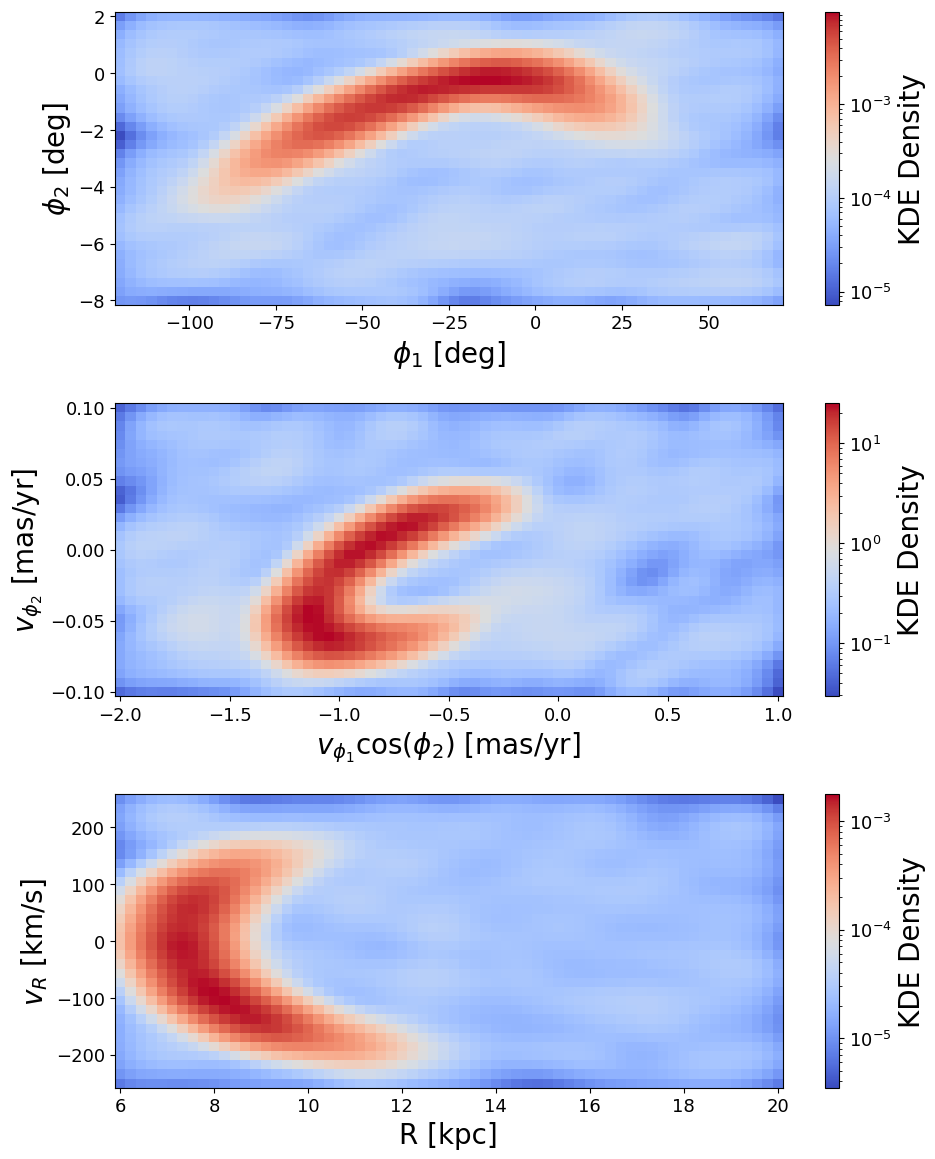

In [ ]:
# #steream stacking and standardization
# stream = jnp.stack((R, phi1, phi2, vR, v1_cosphi2, v2),).T
# #Bernoulli sampling
# @jit
# def selection_function(stream_star, p, key):
#     # Apply selection criteria
#     return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

# key = random.PRNGKey(42)
# keys = random.split(key, stream.shape[0])
# p = jnp.ones(shape=(stream.shape[0]))* 0.95
# selected_stream = jax.vmap(selection_function, )(stream, p, keys)

# @jit 
# def background_assignement(key):
#     # Generate a random background star position
#     return jax.random.uniform(key=key, shape=(6,),
#                               minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
#                              maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

# # Nbackground star contamination
# N_background = int(1e6)
# #Generate the probability of selectin a background star
# background_selected = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
# keys = random.split(key, N_background)
# selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys, background_selected)

# # Combine the selected stream and background stars
# stream = jnp.concatenate((selected_stream, selected_background), axis=0)

# stream = stream[~jnp.isnan(stream)].reshape((-1, 6))  # Remove NaN entries

# R, phi1, phi2, vR, v1_cosphi2, v2 = stream[:, 0], stream[:, 1], stream[:, 2], stream[:, 3], stream[:, 4], stream[:, 5]

# phi1_phi2 = jnp.stack((phi1, phi2), )
# kcde_phi1_phi2 = jax.scipy.stats.gaussian_kde(phi1_phi2)
# fig = plt.figure(figsize=(10, 12), tight_layout=True)
# ax = fig.add_subplot(311)
# phi1_range = jnp.linspace(-120, 70, 64)
# phi2_range = jnp.linspace(-8, 2, 32)
# phi1_grid, phi2_grid = jnp.meshgrid(phi1_range, phi2_range, indexing='ij')
# kde_values_phi1_phi2 = kcde_phi1_phi2(jnp.stack((phi1_grid.ravel(), phi2_grid.ravel()), axis=-1).T)
# kde_values_phi1_phi2 = kde_values_phi1_phi2.reshape(phi1_grid.shape)
# im = ax.pcolormesh(phi1_grid, phi2_grid, kde_values_phi1_phi2, shading='auto', cmap='coolwarm', norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='KDE Density')
# ax.set_xlabel("$\phi_1$ [deg]")
# ax.set_ylabel("$\phi_2$ [deg]")

# v1_cosphi2_v2 = jnp.stack((v1_cosphi2, v2), )
# kcde_v1_cosphi2_v2 = jax.scipy.stats.gaussian_kde(v1_cosphi2_v2)
# ax = fig.add_subplot(312)
# v1_range = jnp.linspace(-2., 1.0, 64)
# v2_range = jnp.linspace(-0.10, 0.10, 32)    
# v1_grid, v2_grid = jnp.meshgrid(v1_range, v2_range, indexing='ij')
# kde_values_v1_cosphi2_v2 = kcde_v1_cosphi2_v2(jnp.stack((v1_grid.ravel(), v2_grid.ravel()), axis=-1).T)
# kde_values_v1_cosphi2_v2 = kde_values_v1_cosphi2_v2.reshape(v1_grid.shape)
# im = ax.pcolormesh(v1_grid, v2_grid, kde_values_v1_cosphi2_v2, shading='auto', cmap='coolwarm', norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='KDE Density')
# ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
# ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")

# R_vR = jnp.stack((R, vR), )
# kcde_R_vR = jax.scipy.stats.gaussian_kde(R_vR)
# ax = fig.add_subplot(313)
# R_range = jnp.linspace(6, 20, 64)
# vR_range = jnp.linspace(-250, 250, 32)
# R_grid, vR_grid = jnp.meshgrid(R_range, vR_range, indexing='ij')
# kde_values_R_vR = kcde_R_vR.evaluate((jnp.stack((R_grid.ravel(), vR_grid.ravel()), axis=-1).T))
# kde_values_R_vR = kde_values_R_vR.reshape(R_grid.shape)
# im = ax.pcolormesh(R_grid, vR_grid, kde_values_R_vR, shading='auto', cmap='coolwarm', norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='KDE Density')
# ax.set_xlabel("R [kpc]")
# ax.set_ylabel("$v_R$ [km/s]")
# plt.show()

Text(0, 0.5, '$v_R$ [km/s]')

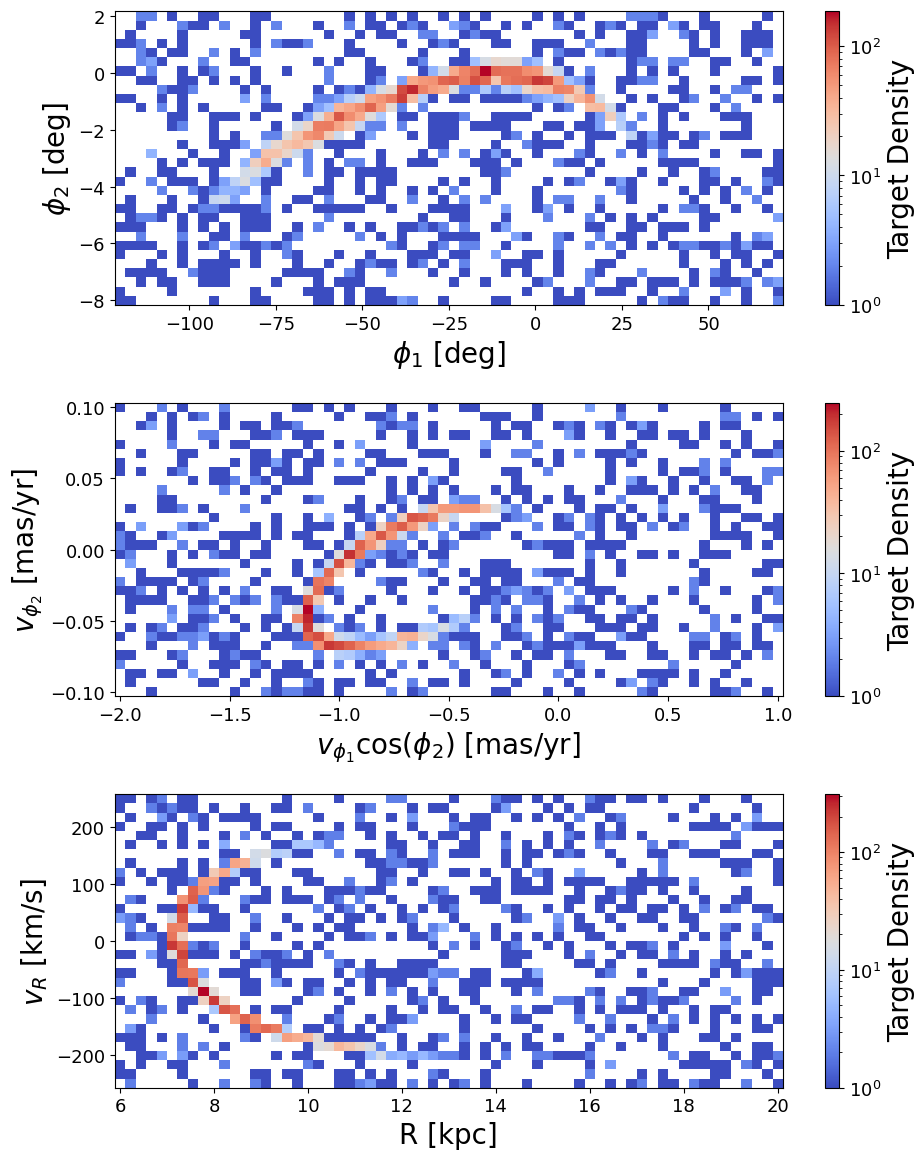

In [ ]:
# target_phi1_phi2 =  jnp.histogram2d(phi1, phi2, bins=[64, 32], range=[[-120, 70], [-8, 2]])[0]
# # target_phi1_phi2 /= jnp.sum(target_phi1_phi2)  # Normalize the histogram
# target_v1_cosphi2_v2 = jnp.histogram2d(v1_cosphi2, v2, bins=[64, 32], range=[[-2, 1.0], [-0.10, 0.10]])[0]
# # target_v1_cosphi2_v2 /= jnp.sum(target_v1_cosphi2_v2)  # Normalize the histogram
# target_R_vR = jnp.histogram2d(R, vR, bins=[64, 32], range=[[6, 20], [-250, 250]])[0]
# # target_R_vR /= jnp.sum(target_R_vR)  # Normalize the histogram

# fig = plt.figure(figsize=(10, 12), tight_layout=True)
# ax = fig.add_subplot(311)
# im = ax.pcolormesh(phi1_grid, phi2_grid, target_phi1_phi2, shading='auto', cmap='coolwarm', norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='Target Density')
# ax.set_xlabel("$\phi_1$ [deg]")
# ax.set_ylabel("$\phi_2$ [deg]")
# ax = fig.add_subplot(312)
# im = ax.pcolormesh(v1_grid, v2_grid, target_v1_cosphi2_v2, shading='auto', cmap='coolwarm', norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='Target Density')
# ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
# ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
# ax = fig.add_subplot(313)
# im = ax.pcolormesh(R_grid, vR_grid, target_R_vR, shading='auto', cmap='coolwarm', norm=colors.LogNorm())
# plt.colorbar(im, ax=ax, label='Target Density')
# ax.set_xlabel("R [kpc]")
# ax.set_ylabel("$v_R$ [km/s]")


In [ ]:
# # for now we will only use the last snapshot to caluclate the loss and the gradient
# config =  config._replace(return_snapshots=False,)
# config = config._replace(progress_bar=False,)
# config_com = config_com._replace(return_snapshots=False,)
# config_com = config_com._replace(progress_bar=False,)

# #Bimodal sampling
# @jit
# def selection_function(stream_star, p, key):
#     # Apply selection criteria
#     return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

# # Generate a random background star position
# @jit 
# def background_assignement(key):
#     return jax.random.uniform(key=key, shape=(6,),
#                               minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
#                              maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

# #we calculate the kde values
# phi1_range = jnp.linspace(-120, 70, 64) 
# phi2_range = jnp.linspace(-8, 2, 32)
# phi1_grid, phi2_grid = jnp.meshgrid(phi1_range, phi2_range, indexing='ij')

# v1_range = jnp.linspace(-2., 1.0, 64)
# v2_range = jnp.linspace(-0.10, 0.10, 32)
# v1_grid, v2_grid = jnp.meshgrid(v1_range, v2_range, indexing='ij')

# R_range = jnp.linspace(6, 20, 64)
# vR_range = jnp.linspace(-250, 250, 32)
# R_grid, vR_grid = jnp.meshgrid(R_range, vR_range, indexing='ij')


# @jit
# def time_integration_NFW_mass_grad(Mvir, key, target_phi1_phi2, target_v1_cosphi2_v2, target_R_vR):

#     #Creation of the Plummer sphere requires a key 
#     key = random.PRNGKey(key)
#     key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

#     #we set up the parameters of the simulations, changing only the parameter that we want to optimize
#     new_params = params._replace(
#                 NFW_params=params.NFW_params._replace(
#                     Mvir=Mvir 
#                 ))
#     new_params_com = params_com._replace(
#                 NFW_params=params_com.NFW_params._replace(
#                     Mvir=Mvir 
#                 ))
#     #Final position and velocity of the center of mass
#     pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
#     vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
#     mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
#     #we construmt the initial state of the com 
#     initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
#     #we run the simulation backwards in time for the center of mass
#     final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
#     #we calculate the final position and velocity of the center of mass
#     pos_com = final_state_com[:, 0]
#     vel_com = final_state_com[:, 1]

#     #we construct the initial state of the Plummer sphere
#     positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
#     #we add the center of mass position and velocity to the Plummer sphere particles
#     positions = positions + pos_com
#     velocities = velocities + vel_com
#     #initialize the initial state
#     initial_state_stream = construct_initial_state(positions, velocities, )
#     #run the simulation
#     final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

#     #projection on the GD1 stream
#     stream = projection_on_GD1(final_state, code_units=code_units,)

#     #Stream selection success
#     keys_selection = random.split(key_selection, stream.shape[0])
#     p = jnp.ones(shape=(stream.shape[0]))* 0.95
#     # selected_stream = jax.vmap(selection_function, )(stream, p, keys_selection)
#     selected_stream =  stream

#     # #background contamination
#     N_background = int(1e6)
#     # #Generate the probability of selectin a background star, this is computationally expensive, so we just add 1_000 background stars
#     # background_selected = jnp.where(jax.random.uniform(key=key_background, shape=(N_background,)) < 1e-3, 1.0, 0.0)
#     # keys_background = random.split(key_background, N_background)
#     # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys_background, background_selected)
#     N_background = int(N_background * 1e-3)
#     selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

#     # Combine the selected stream and background stars
#     stream = jnp.concatenate((selected_stream, selected_background), axis=0)

#     #add gaussian noise to the stream
#     noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
#     stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std


#     #we use kde
#     phi1_phi2 = jnp.stack((stream[:, 1], stream[:, 2]), )
#     R_vR = jnp.stack((stream[:, 0], stream[:, 3]), )
#     v1_cosphi2_v2 = jnp.stack((stream[:, 4], stream[:, 5]), )
#     # Stack the data and create KDEs using a list comprehension
    
#     kde_phi1_phi2 = jax.scipy.stats.gaussian_kde(phi1_phi2)
#     kde_v1_cosphi2_v2 = jax.scipy.stats.gaussian_kde(v1_cosphi2_v2)
#     kde_R_vR = jax.scipy.stats.gaussian_kde(R_vR)
    
    
#     counts_phi1_phi2 = kde_phi1_phi2.evaluate(jnp.stack((phi1_grid.ravel(), phi2_grid.ravel()), axis=-1).T)
#     counts_phi1_phi2 = kde_values_phi1_phi2.reshape(phi1_grid.shape)
#     # counts_phi1_phi2 = counts_phi1_phi2 / jnp.sum(counts_phi1_phi2)

    
#     counts_v1_cosphi2_v2 = kde_v1_cosphi2_v2.evaluate(jnp.stack((v1_grid.ravel(), v2_grid.ravel()), axis=-1).T)
#     counts_v1_cosphi2_v2 = kde_values_v1_cosphi2_v2.reshape(v1_grid.shape)
#     # counts_v1_cosphi2_v2 = counts_v1_cosphi2_v2 / jnp.sum(counts_v1_cosphi2_v2)

    
#     counts_R_vR = kde_R_vR.evaluate(jnp.stack((R_grid.ravel(), vR_grid.ravel()), axis=-1).T)    
#     counts_R_vR = kde_values_R_vR.reshape(R_grid.shape)
#     # counts_R_vR = counts_R_vR / jnp.sum(counts_R_vR)

#     #we calculate the loss
#     loss_phi1_phi2 = jnp.sum((counts_phi1_phi2-target_phi1_phi2)**2)
#     loss_v1_cosphi2_v2 = jnp.sum((counts_v1_cosphi2_v2-target_v1_cosphi2_v2)**2)
#     loss_R_vR = jnp.sum((counts_R_vR-target_R_vR)**2)
    
#     #total loss
#     loss = loss_phi1_phi2 + loss_v1_cosphi2_v2 + loss_R_vR
#     # loss = loss_phi1_phi2

    
#     return loss


# # Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
# Mvir = params.NFW_params.Mvir*8/4
# key = 0
# loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key, target_phi1_phi2, target_v1_cosphi2_v2, target_R_vR)
# # loss = time_integration_NFW_mass_grad(Mvir, key, target_phi1_phi2, target_v1_cosphi2_v2, target_R_vR)
# print("Gradient of the total mass of the Mvir of NFW:\n", grad)
# print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 0.0
Loss:
 1385596.2


In [ ]:
# n_sim = 99
# keys = jnp.arange(n_sim+1)
# Mvir = np.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim) 
# # Correct way to append - assign the result back to Mvir
# Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
# Mvir = jnp.array(np.sort(Mvir))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# # loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
# @jit
# def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
#     Mvir, key, = Mvir_and_key_NF
#     return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

# loss, grad = jax.lax.map(
#     time_integration_NFW_mass_grad_map, 
#     (Mvir_sharded, keys_sharded,), 
#     batch_size=2
# )

# plt.figure()
# plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
# plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
# plt.xlabel("$M_{vir}$ [$M_\odot$]")
# plt.ylabel('Loss')
# plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass.pdf')

TypeError: time_integration_NFW_mass_grad() missing 3 required positional arguments: 'target_phi1_phi2', 'target_v1_cosphi2_v2', and 'target_R_vR'

# Use KS test in each of the dimensions


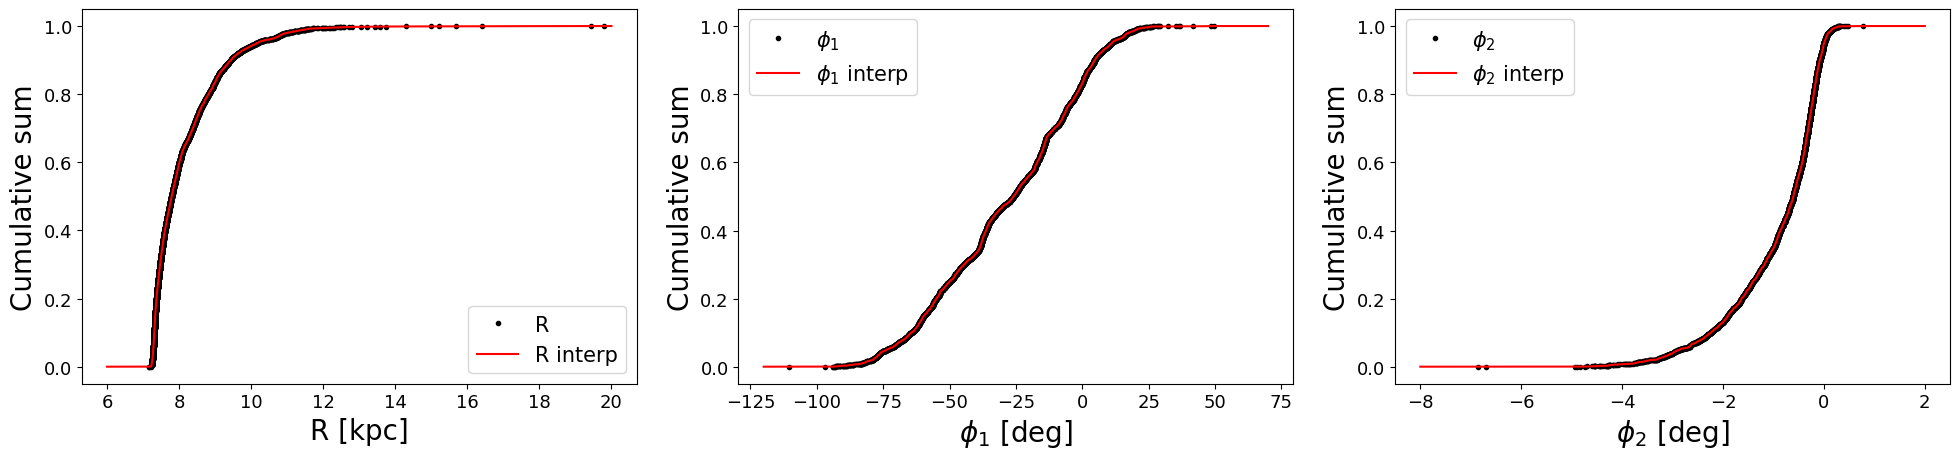

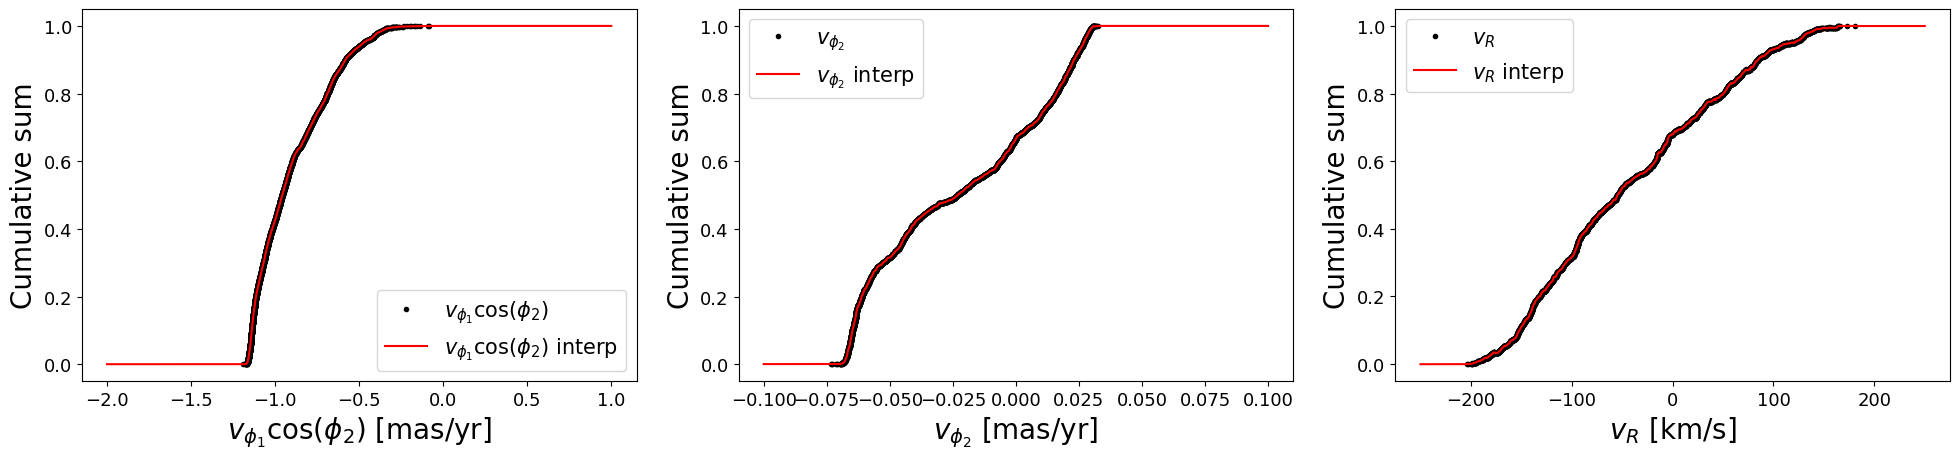

In [ ]:
stream = projection_on_GD1(final_state, code_units=code_units,)
R, phi1, phi2, vR, v1_cosphi2, v2 = stream[:, 0], stream[:, 1], stream[:, 2], stream[:, 3], stream[:, 4], stream[:, 5]

n_interp_point = 500
#observational window
phi1_window = jnp.linspace(-120, 70, n_interp_point)    # 64 bins
phi2_window = jnp.linspace(-8, 2, n_interp_point)       # 32 bins
v1_window = jnp.linspace(-2., 1.0, n_interp_point)      # 64 bins  
v2_window = jnp.linspace(-0.10, 0.10, n_interp_point)   # 32 bins
R_window = jnp.linspace(6, 20, n_interp_point)          # 64 bins
vR_window = jnp.linspace(-250, 250, n_interp_point)     # 32 bins

R_cumsum_interp_target = jnp.interp(R_window, jnp.sort(R), jnp.cumsum(R)/jnp.sum(R))   
phi1_cumsum_interp_target = jnp.interp(phi1_window, jnp.sort(phi1), jnp.cumsum(phi1)/jnp.sum(phi1))
phi2_cumsum_interp_target = jnp.interp(phi2_window, jnp.sort(phi2), jnp.cumsum(phi2)/jnp.sum(phi2))    
v1_cumsum_interp_target = jnp.interp(v1_window, jnp.sort(v1_cosphi2), jnp.cumsum(v1_cosphi2)/jnp.sum(v1_cosphi2))
v2_cumsum_interp_target = jnp.interp(v2_window, jnp.sort(v2), jnp.cumsum(v2)/jnp.sum(v2))
vR_cumsum_interp_targeet = jnp.interp(vR_window, jnp.sort(vR), jnp.cumsum(vR)/jnp.sum(vR))
fig = plt.figure(figsize=(20, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.plot(jnp.sort(R), jnp.cumsum(R)/jnp.sum(R), 'k.', label='R')
ax.plot(R_window, R_cumsum_interp_target, 'r-', label='R interp')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("Cumulative sum")
ax.legend()
ax = fig.add_subplot(132)
ax.plot(jnp.sort(phi1), jnp.cumsum(phi1)/jnp.sum(phi1), 'k.', label='$\phi_1$')
ax.plot(phi1_window, phi1_cumsum_interp_target, 'r-', label='$\phi_1$ interp') 
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("Cumulative sum")
ax.legend()
ax = fig.add_subplot(133)
ax.plot(jnp.sort(phi2), jnp.cumsum(phi2)/jnp.sum(phi2), 'k.', label='$\phi_2$') 
ax.plot(phi2_window, phi2_cumsum_interp_target, 'r-', label='$\phi_2$ interp')
ax.set_xlabel("$\phi_2$ [deg]")
ax.set_ylabel("Cumulative sum")
ax.legend()
fig = plt.figure(figsize=(20, 5), tight_layout=True)
ax = fig.add_subplot(131)
ax.plot(jnp.sort(v1_cosphi2), jnp.cumsum(v1_cosphi2)/jnp.sum(v1_cosphi2), 'k.', label='$v_{\phi_1}\cos(\phi_2)$')
ax.plot(v1_window, v1_cumsum_interp_target, 'r-', label='$v_{\phi_1}\cos(\phi_2)$ interp')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("Cumulative sum")
ax.legend()
ax = fig.add_subplot(132)   
ax.plot(jnp.sort(v2), jnp.cumsum(v2)/jnp.sum(v2), 'k.', label='$v_{\phi_2}$')
ax.plot(v2_window, v2_cumsum_interp_target, 'r-', label='$v_{\phi_2}$ interp')
ax.set_xlabel("$v_{\phi_2}$ [mas/yr]")
ax.set_ylabel("Cumulative sum")
ax.legend()
ax = fig.add_subplot(133)
ax.plot(jnp.sort(vR), jnp.cumsum(vR)/jnp.sum(vR), 'k.', label='$v_R$')
ax.plot(vR_window, vR_cumsum_interp_targeet, 'r-', label='$v_R$ interp')
ax.set_xlabel("$v_R$ [km/s]")
ax.set_ylabel("Cumulative sum")
ax.legend()

In [ ]:
final_state_target = final_state.copy().reshape(-1, 6)

In [ ]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config = config._replace(progress_bar=False,)
config_com = config_com._replace(return_snapshots=False,)
config_com = config_com._replace(progress_bar=False,)

#Bimodal sampling
@jit
def selection_function(stream_star, p, key):
    # Apply selection criteria
    return jnp.where(jax.random.uniform(key=key, shape=1) < p, stream_star, jnp.nan)

# Generate a random background star position
@jit 
def background_assignement(key):
    return jax.random.uniform(key=key, shape=(6,),
                              minval=jnp.array([6, -120, -8, -250, -2., -0.10]),
                             maxval=jnp.array([20, 70, 2, 250, 1.0, 0.10]))

@jit
def interp_cumsum(data, windows):
    """
    Interpolate the cumulative sum of the data over the given windows.
    """
    sorted_data = jnp.sort(data)
    cumsum_data = jnp.cumsum(sorted_data) / jnp.sum(sorted_data)
    return jnp.interp(windows, sorted_data, cumsum_data)


@jit
def time_integration_NFW_mass_grad(Mvir, key, ):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)
    final_state = final_state.reshape(-1, 6)


    #Stream selection success
    keys_selection = random.split(key_selection, stream.shape[0])
    p = jnp.ones(shape=(stream.shape[0]))* 0.95
    # selected_stream = jax.vmap(selection_function, )(stream, p, keys_selection)
    selected_stream =  stream

    # #background contamination
    N_background = int(1e6)
    # #Generate the probability of selectin a background star, this is computationally expensive, so we just add 1_000 background stars
    # background_selected = jnp.where(jax.random.uniform(key=key_background, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    # keys_background = random.split(key_background, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys_background, background_selected)
    N_background = int(N_background * 1e-3)
    selected_background = jax.vmap(background_assignement, )(random.split(key=key_background, num=N_background))

    # Combine the selected stream and background stars
    stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std

    #We want to minimize the mean absolute discrepancy between the target and simulated comulative distributions
    R, phi1, phi2, vR, v1_cosphi2, v2 = stream[:, 0], stream[:, 1], stream[:, 2], stream[:, 3], stream[:, 4], stream[:, 5]
    # Interpolate the cumulative sums
    # R_cumsum_interp = interp_cumsum(R, R_window)
    # phi1_cumsum_interp = interp_cumsum(phi1, phi1_window)
    # phi2_cumsum_interp = interp_cumsum(phi2, phi2_window)
    # v1_cumsum_interp = interp_cumsum(v1_cosphi2, v1_window)
    # v2_cumsum_interp = interp_cumsum(v2, v2_window)
    # vR_cumsum_interp = interp_cumsum(vR, vR_window)

    cumsum_interp = jax.vmap(interp_cumsum, )(jnp.stack((R, phi1, phi2, v1_cosphi2, v2, vR), axis=0),
                                             jnp.stack((R_window, phi1_window, phi2_window, v1_window, v2_window, vR_window), axis=0))
    R_cumsum_interp, phi1_cumsum_interp, phi2_cumsum_interp, v1_cumsum_interp, v2_cumsum_interp, vR_cumsum_interp = cumsum_interp

    loss = (
        jnp.sum(jnp.abs(R_cumsum_interp - R_cumsum_interp_target)) +
        jnp.sum(jnp.abs(phi1_cumsum_interp - phi1_cumsum_interp_target)) +
        jnp.sum(jnp.abs(phi2_cumsum_interp - phi2_cumsum_interp_target)) +
        jnp.sum(jnp.abs(v1_cumsum_interp - v1_cumsum_interp_target)) +
        jnp.sum(jnp.abs(v2_cumsum_interp - v2_cumsum_interp_target)) +
        jnp.sum(jnp.abs(vR_cumsum_interp - vR_cumsum_interp_targeet))
    )

    
    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*8/4
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key, )
# loss = time_integration_NFW_mass_grad(Mvir, key, target_phi1_phi2, target_v1_cosphi2_v2, target_R_vR)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 -0.00014852773
Loss:
 896.1585


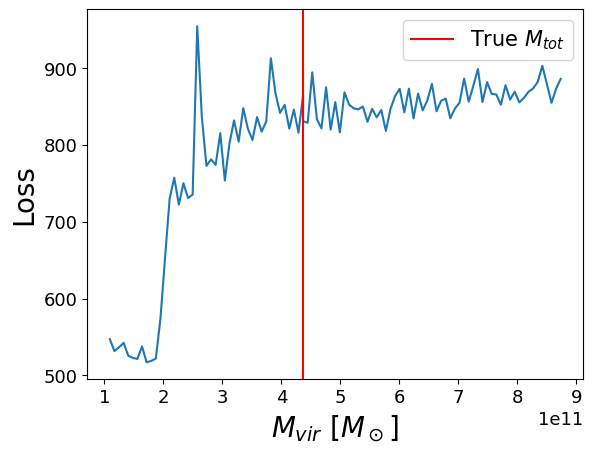

In [ ]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
    Mvir, key, = Mvir_and_key_NF
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded,), 
    batch_size=2
)

plt.figure()
plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass.pdf')

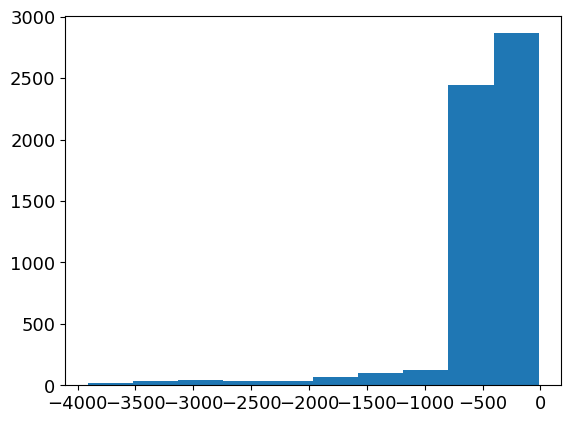

In [45]:
log_prob = flow.log_prob((stream[~jnp.isnan(stream)].reshape(-1, 6) -stream_mean)/stream_std)
# log_prob /= jnp.sum(log_prob)  # Normalize the log probability by the sum of the standard deviations
plt.hist(log_prob, density=False);

# Parameters

# NFW Mass

In [18]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

# @jit
def time_integration_NFW_mass_grad(Mvir, key):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    final_state = final_state.reshape(-1, 6)


    #Stream selection success
    # key = random.PRNGKey(42)
    # keys = random.split(key, stream.shape[0])
    # p = jnp.ones(shape=(stream.shape[0]))* 0.95
    # selected_stream = jax.vmap(selection_function, )(stream, p, keys)
    # selected_stream =  stream

    # N_background = int(1e6)
    # #Generate the probability of selectin a background star, this is computationally expensive, so we just add 1_000 background stars
    # background_selected = jnp.where(jax.random.uniform(key=key_background, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    # keys_background = random.split(key_background, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys_background, background_selected)


    # stream = selected_stream

    
    # log_prob /= jnp.sum(log_prob)

    # loss = -jnp.sum(log_prob)  # We want to minimize the negative log likelihood
    # loss = -jnp.sum(jnp.where(log_prob < 0, log_prob, 0))
    # plt.hist(log_prob, density=False);

    
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(final_state), len(final_state_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(final_state_target))(final_state))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(final_state_target))(final_state_target))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(final_state))(final_state))
    
    return xx + yy - 2 * xy



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
# loss = time_integration_NFW_mass_grad(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 -1.00227055e-07
Loss:
 -0.003773192


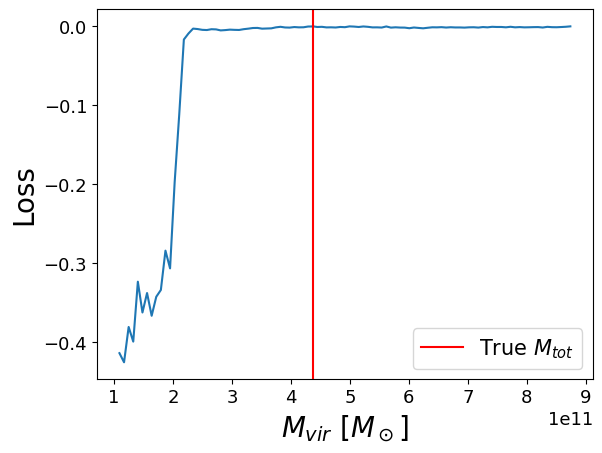

In [ ]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key_NF):
    Mvir, key, = Mvir_and_key_NF
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key, )

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded,), 
    batch_size=2
)

plt.figure()
plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass.pdf')

## NFW_r_s

In [23]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_NFW_r_s_grad(r_s, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    r_s=r_s 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    r_s=r_s 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
r_s = params.NFW_params.r_s*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_r_s_grad, )(r_s, key)
print("Gradient of the total mass of the r_s of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the r_s of NFW:
 406580.7
Loss:
 2599.198


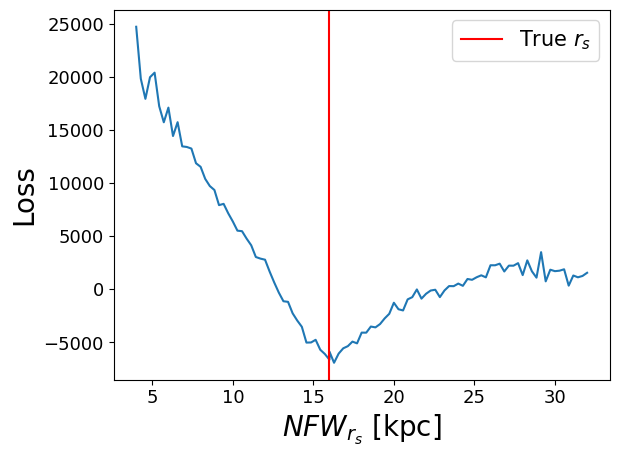

In [24]:
n_sim = 99
keys = jnp.arange(n_sim+1)
r_s = np.linspace(params.NFW_params.r_s*(1/4), params.NFW_params.r_s*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
r_s = np.concatenate([r_s, np.array([params.NFW_params.r_s])]) # Append the true Mvir value
r_s = jnp.array(np.sort(r_s))

mesh = Mesh(np.array(jax.devices()), ("i",))
r_s_sharded = jax.device_put(r_s, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_r_s_grad_map(r_s_and_key):
    r_s, key = r_s_and_key
    return jax.value_and_grad(time_integration_NFW_r_s_grad)(r_s, key)

loss, grad = jax.lax.map(
    time_integration_NFW_r_s_grad_map, 
    (r_s_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(r_s_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.NFW_params.r_s*(code_units.code_length).to(u.kpc), color='r', label='True $r_{s}$')
plt.xlabel("$NFW_{r_s}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_NFW_rs.pdf')

# Miamoto Nagai Parameters

# Mass of MN

In [25]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_M_grad(M, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    M=M 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    M=M 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M = params.MN_params.M*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_M_grad, )(M, key)
print("Gradient of the total mass of the M of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the M of MN:
 -0.0021597715
Loss:
 -4100.459


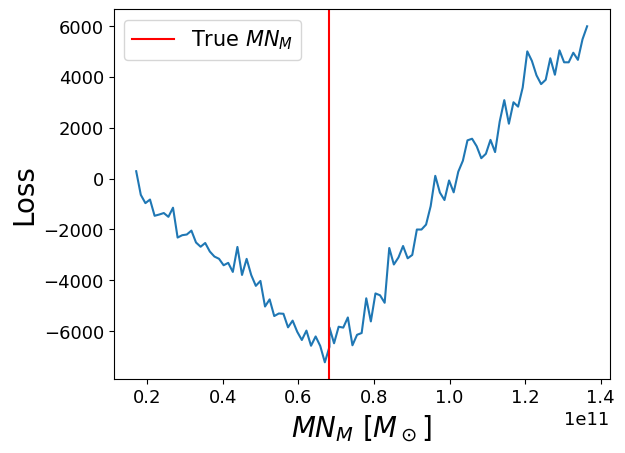

In [26]:
n_sim = 99
keys = jnp.arange(n_sim+1)
M = np.linspace(params.MN_params.M*(1/4), params.MN_params.M*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
M = np.concatenate([M, np.array([params.MN_params.M])]) # Append the true Mvir value
M = jnp.array(np.sort(M))

mesh = Mesh(np.array(jax.devices()), ("i",))
M_sharded = jax.device_put(M, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_M_grad_map(M_and_key):
    M, key = M_and_key
    return jax.value_and_grad(time_integration_MN_M_grad)(M, key)

loss, grad = jax.lax.map(
    time_integration_MN_M_grad_map, 
    (M_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(M_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.MN_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $MN_{M}$')
plt.xlabel("$MN_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_MN_mass.pdf')

# a of MN

In [27]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_a_grad(a, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    a=a 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    a=a 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
a = params.MN_params.a*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_a_grad, )(a, key)
print("Gradient of the total mass of the a of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the a of MN:
 -13463.969
Loss:
 -4057.2356


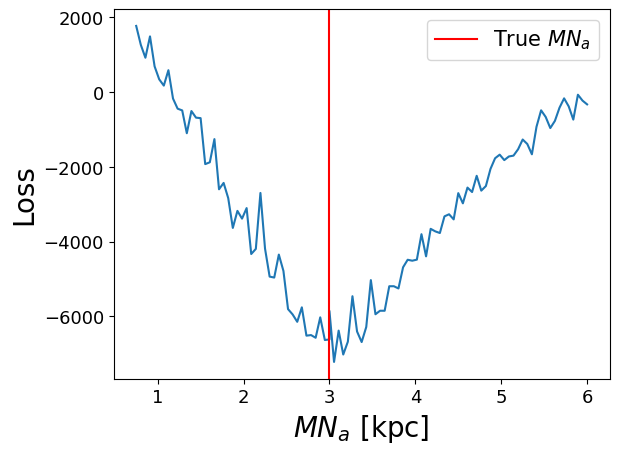

In [28]:
n_sim = 99
keys = jnp.arange(n_sim+1)
a = np.linspace(params.MN_params.a*(1/4), params.MN_params.a*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
a = np.concatenate([a, np.array([params.MN_params.a])]) # Append the true Mvir value
a = jnp.array(np.sort(a))

mesh = Mesh(np.array(jax.devices()), ("i",))
a_sharded = jax.device_put(a, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_a_grad_map(a_and_key):
    a, key = a_and_key
    return jax.value_and_grad(time_integration_MN_a_grad)(a, key)

loss, grad = jax.lax.map(
    time_integration_MN_a_grad_map, 
    (a_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(a_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.MN_params.a*(code_units.code_length).to(u.kpc), color='r', label='True $MN_{a}$')
plt.xlabel("$MN_{a}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_MN_a.pdf')

# b of MN

In [29]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_MN_b_grad(b, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                MN_params=params.MN_params._replace(
                    b=b 
                ))
    new_params_com = params_com._replace(
                MN_params=params_com.MN_params._replace(
                    b=b 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
b = params.MN_params.b*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_MN_a_grad, )(b, key)
print("Gradient of the total mass of the a of MN:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the a of MN:
 16670.475
Loss:
 3844.4019


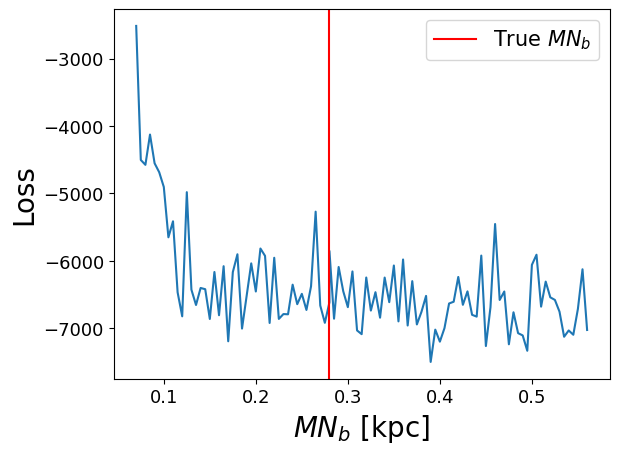

In [30]:
n_sim = 99
keys = jnp.arange(n_sim+1)
b = np.linspace(params.MN_params.b*(1/4), params.MN_params.b*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
b = np.concatenate([b, np.array([params.MN_params.b])]) # Append the true Mvir value
b = jnp.array(np.sort(b))

mesh = Mesh(np.array(jax.devices()), ("i",))
b_sharded = jax.device_put(b, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_MN_b_grad_map(b_and_key):
    b, key = b_and_key
    return jax.value_and_grad(time_integration_MN_b_grad)(b, key)

loss, grad = jax.lax.map(
    time_integration_MN_b_grad_map, 
    (b_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(b_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.MN_params.b*(code_units.code_length).to(u.kpc), color='r', label='True $MN_{b}$')
plt.xlabel("$MN_{b}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_MN_b.pdf')

# PSP parameters

# M of PSP

In [31]:
config_com = config_com._replace(return_snapshots=False,)
config = config._replace(return_snapshots=False,)

@jit
def time_integration_PSP_M_grad(M, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    M=M 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    M=M 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot])
    #we construmt the initial state of the com  
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]
    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)
    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,) 
    #we calculate the loss as the negative log likelihood of the stream
    log_prob = flow.log_prob((stream-stream_mean)/stream_std)
    # Subtract the mean and divde by the std for normalization
    loss = -jnp.sum(log_prob)
    return loss

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
M = params.PSP_params.M*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_M_grad, )(M, key)
print("Gradient of the total mass of the M of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the M of PSP:
 -0.006524218
Loss:
 -5971.657


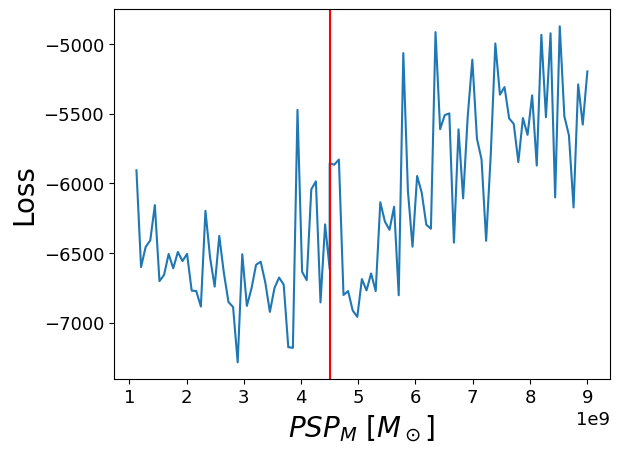

In [32]:
n_sim = 99
keys = jnp.arange(n_sim+1)
M = np.linspace(params.PSP_params.M*(1/4), params.PSP_params.M*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
M = np.concatenate([M, np.array([params.PSP_params.M])])  # Append the true Mvir value
M = jnp.array(np.sort(M))
mesh = Mesh(np.array(jax.devices()), ("i",))
M_sharded = jax.device_put(M, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_M_grad_map(M_and_key):
    M, key = M_and_key
    return jax.value_and_grad(time_integration_PSP_M_grad)(M, key)
loss, grad = jax.lax.map(
    time_integration_PSP_M_grad_map, 
    (M_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(M_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.PSP_params.M*(code_units.code_mass).to(u.Msun), color='r', label='True $PSP_{M}$')
plt.xlabel("$PSP_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.savefig('./loss_landscape/loss_landscape_PSP_mass.pdf')

# alpha of PSP

In [33]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_PSP_alpha_grad(alpha, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    alpha=alpha 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    alpha=alpha 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)

    return -jnp.sum(log_prob)  # Subtract the mean and divde by the std for normalization

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
alpha = 2.9
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_alpha_grad, )(alpha, key)
print("Gradient of the total mass of the alpha of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the alpha of PSP:
 16159.055
Loss:
 -5423.3755


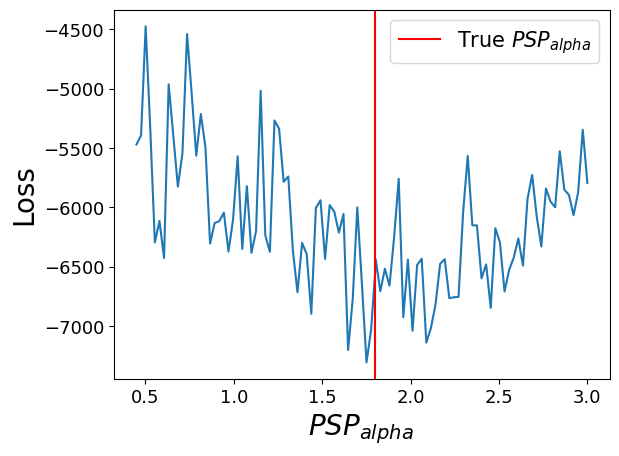

In [34]:
n_sim = 99
keys = jnp.arange(n_sim+1)
alpha = np.linspace(params.PSP_params.alpha*(1/4), 3, n_sim)
# Correct way to append - assign the result back to Mvir
alpha = np.concatenate([alpha, np.array([params.PSP_params.alpha])])  # Append the true Mvir value
alpha = jnp.array(np.sort(alpha))
mesh = Mesh(np.array(jax.devices()), ("i",))
alpha_sharded = jax.device_put(alpha, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_alpha_grad_map(alpha_and_key):
    alpha, key = alpha_and_key
    return jax.value_and_grad(time_integration_PSP_alpha_grad)(alpha, key)
loss, grad = jax.lax.map(
    time_integration_PSP_alpha_grad_map, 
    (alpha_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(alpha_sharded, loss)
plt.axvline(params.PSP_params.alpha, color='r', label='True $PSP_{alpha}$')
plt.xlabel("$PSP_{alpha}$ ")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_PSP_alpha.pdf')

# r_c of PSP

In [35]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit

def time_integration_PSP_r_c_grad(r_c, key):
    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                PSP_params=params.PSP_params._replace(
                    r_c=r_c 
                ))
    new_params_com = params_com._replace(
                PSP_params=params_com.PSP_params._replace(
                    r_c=r_c 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)
    return -jnp.sum(log_prob)

# Calculate the value of the function and the gradient wrt the r_c of the PSP
r_c = params.PSP_params.r_c*(3/4)
key = 0
loss, grad = jax.value_and_grad(time_integration_PSP_r_c_grad, )(r_c, key)
print("Gradient of the total mass of the r_c of PSP:\n", grad)
print("Loss:\n", loss)

Gradient of the total mass of the r_c of PSP:
 1.4526585e-29
Loss:
 -4862.2305


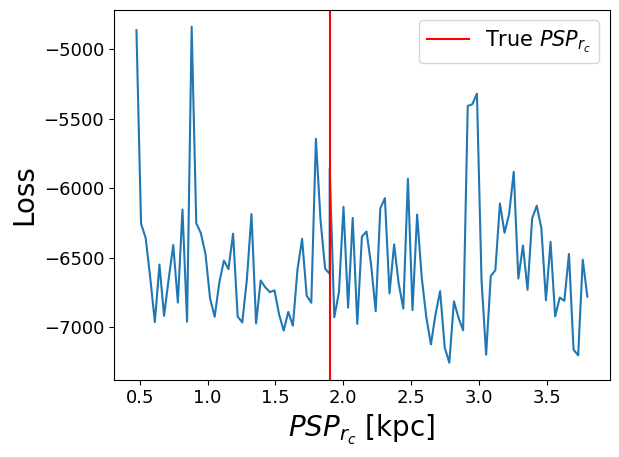

In [36]:
n_sim = 99
keys = jnp.arange(n_sim+1)
r_c = np.linspace(params.PSP_params.r_c*(1/4), params.PSP_params.r_c*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
r_c = np.concatenate([r_c, np.array([params.PSP_params.r_c])])  # Append the true Mvir value
r_c = jnp.array(np.sort(r_c))
mesh = Mesh(np.array(jax.devices()), ("i",))
r_c_sharded = jax.device_put(r_c, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_PSP_r_c_grad_map(r_c_and_key):
    r_c, key = r_c_and_key
    return jax.value_and_grad(time_integration_PSP_r_c_grad)(r_c, key)
loss, grad = jax.lax.map(
    time_integration_PSP_r_c_grad_map, 
    (r_c_sharded, keys_sharded), 
    batch_size=2
)
plt.figure()
plt.plot(r_c_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.PSP_params.r_c*(code_units.code_length).to(u.kpc), color='r', label='True $PSP_{r_c}$')
plt.xlabel("$PSP_{r_c}$ [kpc]")
plt.ylabel('Loss')
plt.legend()
plt.savefig('./loss_landscape/loss_landscape_PSP_rc.pdf')

# Combined parameters

## t_end and t_end_vs_NFW_mass

Gradient of the total mass of the t_end:
 3.850287
Loss:
 0.033789277


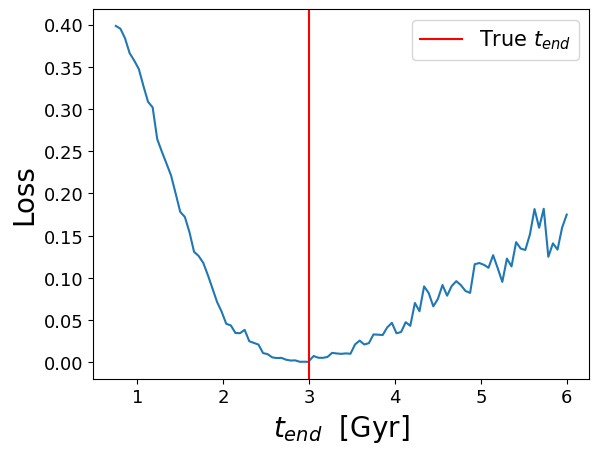

In [13]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_tend_grad(t_end, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    N_background = int(1e6)
    #Generate the probability of selectin a background star
    background_selected = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    keys = random.split(key, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys, background_selected)

    # Combine the selected stream and background stars
    # stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream
    # log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    # loss = -jnp.sum(log_prob)
    # loss = -jnp.sum(jnp.where(log_prob < 0, log_prob, 0))
    # loss = -jnp.mean(log_prob)

     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy


    
    # weights = jnp.where(distances_from_center > new_params.Plummer_params.a, 2.0, 1.0)
    # weights = distances_from_center**4
    # log_prob = flow.log_prob((stream - stream_mean) / stream_std)
    # weighted_loss = -jnp.sum(weights * log_prob) / jnp.sum(weights)
    # weighted_loss = -jnp.sum(weights * log_prob) 
    # loss = weighted_loss
    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_tend_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  
n_sim = 99
keys = jnp.arange(n_sim+1)
t_end = np.linspace(params.t_end*(1/4), params.t_end*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
t_end = jnp.array(np.sort(t_end))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
t_end_sharded = jax.device_put(t_end, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_NFW_tend_map(t_end_and_key):
    t_end, key = t_end_and_key
    return jax.value_and_grad(time_integration_tend_grad)(t_end, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (t_end_sharded, keys_sharded), 
    batch_size=10,
)

plt.figure()
plt.plot(t_end*(code_units.code_time).to(u.Gyr), loss)
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$  [Gyr]")
plt.ylabel('Loss')
plt.legend()
# plt.savefig('./loss_landscape/loss_landscape_t_end.pdf')


Gradient of the total mass of the Mvir of NFW:
 (Array(8.0349416e-10, dtype=float32), Array(-0.03154945, dtype=float32))
Loss:
 0.26993963


Text(0.5, 1.0, 'loss_landscape')

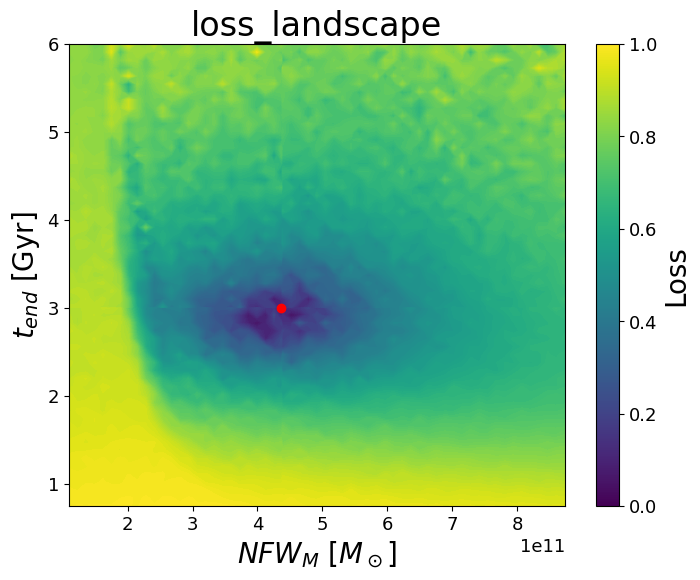

In [14]:
# Gradient on the loss for 2 parameters
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_NFWmass_tend_grad(Mvir, t_end, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params = new_params._replace(
                t_end=t_end,  # Update the t_end parameter
                )
    
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    
    #we also update the t_end parameter for the center of mass
    new_params_com = new_params_com._replace(
                t_end=-t_end,  # Update the t_end parameter for the center of mass
                )
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream


     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # # Compute MMD terms
    # xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    # yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    # xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    # return xx + yy - 2 * xy

    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.15, 0.2, 0.3, 0.25, 0.1])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)

    


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = 0
loss, grad = jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  
n_sim = 60

M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.sort(M_tot_values)
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jnp.arange(len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=[0, 1, ])(Mvir, t_end, key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=10)

loss = loss.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), jnp.log10(loss.T), levels=100, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss_landscape")
# plt.savefig('./loss_landscape/loss_landscape_NFW_mass_tend_20x20.pdf', dpi=300, bbox_inches='tight')


Text(0.5, 1.0, 'loss_landscape')

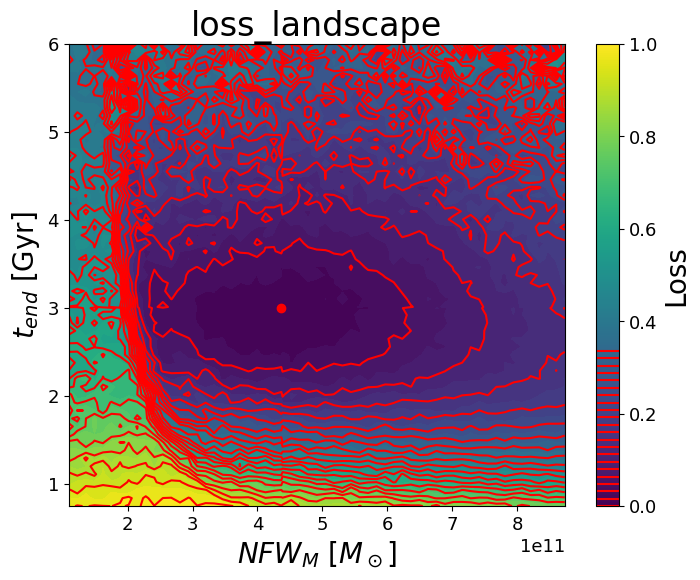

In [15]:
# Plot the heatmap
plt.figure(figsize=(8, 6))
ax = plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=50, cmap="viridis")
CS2 = plt.contour(ax, levels=ax.levels[::2], colors='r')
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
cbar = plt.colorbar(label="Loss")
cbar.add_lines(CS2)
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss_landscape")

# Plummer scale radius

In [39]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

# @jit
def time_integration_Plummer_a_grad(a, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                Plummer_params=params.Plummer_params._replace(
                    a=a
                ))
    new_params_com = params_com._replace(
                Plummer_params=params_com.Plummer_params._replace(
                    a=a 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = params.Plummer_params.a*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_Plummer_a_grad, )(Mtot, key)
print("Gradient of the total mass of the Plummer:\n", grad)
print("Loss:\n", loss)  



Gradient of the total mass of the Plummer:
 -33696.89
Loss:
 -5633.392


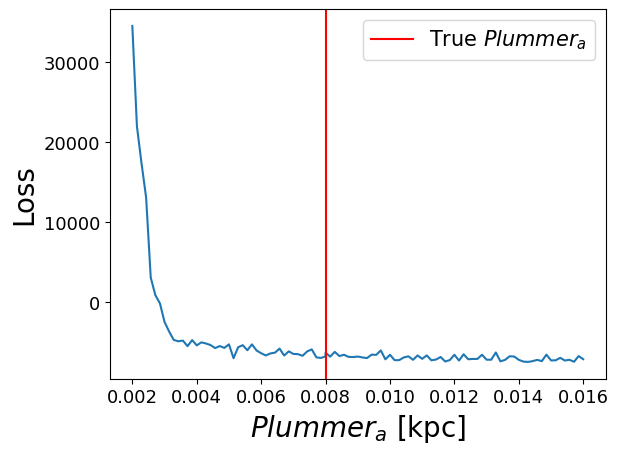

In [40]:

n_sim = 99
keys = jnp.arange(n_sim+1)
a = np.linspace(params.Plummer_params.a*(1/4), params.Plummer_params.a*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
a = np.concatenate([a, np.array([params.Plummer_params.a])]) # Append the true Mvir value
a = jnp.array(np.sort(a))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# a_sharded = jax.device_put(a, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

a_sharded = a
keys_sharded = keys

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_Plummer_a_grad_map(a_and_key):
    a, key = a_and_key
    return jax.value_and_grad(time_integration_Plummer_a_grad)(a, key)

loss, grad = jax.lax.map(
    time_integration_Plummer_a_grad_map, 
    (a_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.plot(a_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(params.Plummer_params.a*(code_units.code_length).to(u.kpc), color='r', label='True $Plummer_{a}$')
plt.xlabel("$Plummer_{a}$ [kpc]")
plt.ylabel('Loss')
plt.legend()

# Plummer mass

Since it is linked to the single star particle it needs lots of memory to compute


In [19]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


# @jit
def time_integration_Plummer_M_grad(Mtot, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                Plummer_params=params.Plummer_params._replace(
                    Mtot=Mtot
                ))
    new_params_com = params_com._replace(
                Plummer_params=params_com.Plummer_params._replace(
                    Mtot=Mtot 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream


    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mtot = params.Plummer_params.Mtot*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_Plummer_M_grad, )(Mtot, key)
print("Gradient of the total mass of the Plummer:\n", grad)
print("Loss:\n", loss)  



Gradient of the total mass of the Plummer:
 -0.00011421883
Loss:
 0.002040267


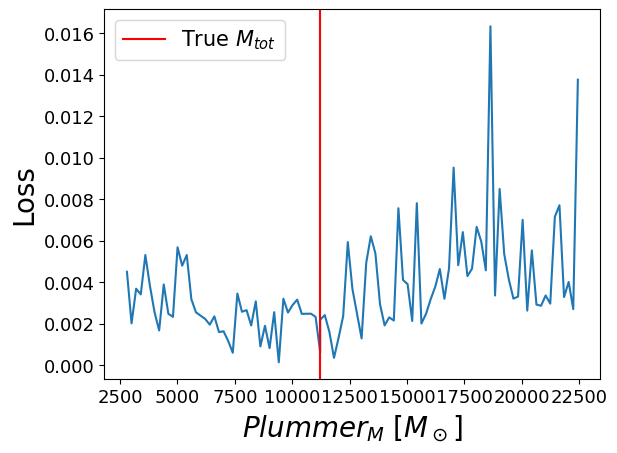

In [20]:
n_sim = 99
keys = jnp.arange(n_sim+1)
Mtot = np.linspace(params.Plummer_params.Mtot*(1/4), params.Plummer_params.Mtot*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
Mtot = np.concatenate([Mtot, np.array([params.Plummer_params.Mtot])]) # Append the true Mvir value
Mtot = jnp.array(np.sort(Mtot))

# mesh = Mesh(np.array(jax.devices()), ("i",))
# Mtot_sharded = jax.device_put(Mtot, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

Mtot_sharded = Mtot
keys_sharded = keys

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_Plummer_M_grad_map(Mtot_and_key):
    Mtot, key = Mtot_and_key
    return jax.value_and_grad(time_integration_Plummer_M_grad)(Mtot, key)

loss, grad = jax.lax.map(
    time_integration_Plummer_M_grad_map, 
    (Mtot_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.plot(Mtot_sharded*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.Plummer_params.Mtot*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$Plummer_{M}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()

# Initial position Loss

In [13]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_xpos_grad(x_pos, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x_pos, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

    return loss

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
x_pos = 10.0 * u.kpc.to(code_units.code_length)
key = 0
loss, grad = jax.value_and_grad(time_integration_xpos_grad, )(x_pos, key)
print("Gradient of the x position of the center of mass:\n", grad)
print("Loss:\n", loss)

Gradient of the x position of the center of mass:
 -19426.936
Loss:
 0.44479352


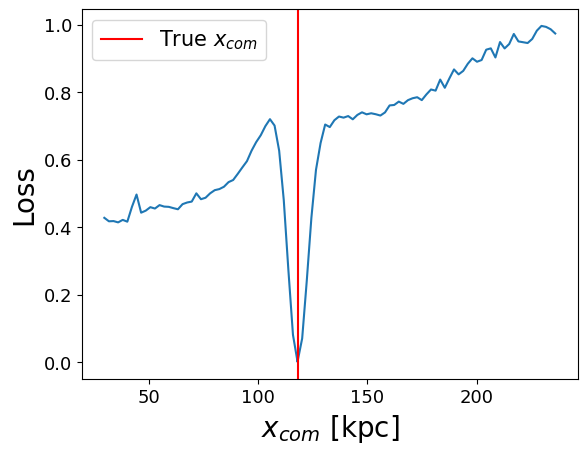

In [14]:
n_sim = 99
keys = jnp.arange(n_sim+1)
x_pos = np.linspace(11.8*(1/4), 11.8*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
x_pos = np.concatenate([x_pos, np.array([11.8])])  # Append the true x position value
x_pos = jnp.array(np.sort(x_pos))
mesh = Mesh(np.array(jax.devices()), ("i",))
x_pos_sharded = jax.device_put(x_pos, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_xpos_grad_map(x_pos_and_key):
    x_pos, key = x_pos_and_key
    return jax.value_and_grad(time_integration_xpos_grad)(x_pos, key)
loss, grad = jax.lax.map(
    time_integration_xpos_grad_map, 
    (x_pos_sharded, keys_sharded), 
    batch_size=1
)
plt.figure()
plt.plot(x_pos_sharded*(code_units.code_length).to(u.kpc), loss)
plt.axvline(11.8*(code_units.code_length).to(u.kpc), color='r', label='True $x_{com}$')
plt.xlabel("$x_{com}$ [kpc]")
plt.ylabel('Loss')
plt.legend()


In [15]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_xy_grad(x_pos, y_pos, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[x_pos, y_pos, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
x_pos = 11.8 * u.kpc.to(code_units.code_length)
y_pos = 0.79 * u.kpc.to(code_units.code_length)
key = 0
loss, grad = jax.value_and_grad(time_integration_xy_grad, )(x_pos, y_pos, key)
print("Gradient of the x and y position of the center of mass:\n", grad)
print("Loss:\n", loss)


Gradient of the x and y position of the center of mass:
 3943013.2
Loss:
 0.4485926


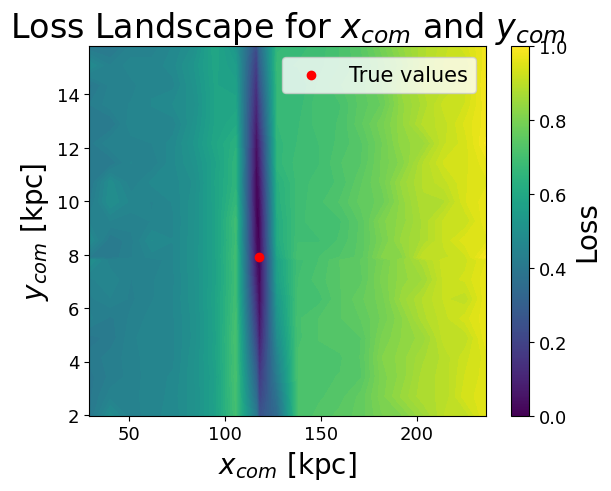

In [16]:
n_sim = 20
keys = jnp.arange(n_sim+1)
x_pos = np.linspace(11.8*(1/4), 11.8*(8/4), n_sim)
y_pos = np.linspace(0.79*(1/4), 0.79*(8/4), n_sim)

x_pos = np.concatenate([x_pos, np.array([11.8])])  # Append the true x position value
y_pos = np.concatenate([y_pos, np.array([0.79])])  # Append the true y position value
x_pos = jnp.array(np.sort(x_pos))
y_pos = jnp.array(np.sort(y_pos))

xx, yy = jnp.meshgrid(x_pos, y_pos, indexing="ij")
# Flatten the grid for vectorized computation
x_pos_flat = xx.flatten()
y_pos_flat = yy.flatten()
keys_flat = jnp.arange(len(x_pos_flat))  # Create a flat array of keys
mesh = Mesh(np.array(jax.devices()), ("i",))
x_pos_sharded = jax.device_put(x_pos_flat, NamedSharding(mesh, PartitionSpec("i")))
y_pos_sharded = jax.device_put(y_pos_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))
@jit
def time_integration_xy_grad_map(xy_and_key):
    x_pos, y_pos, key = xy_and_key
    return jax.value_and_grad(time_integration_xy_grad)(x_pos, y_pos, key)
loss, grad = jax.lax.map(
    time_integration_xy_grad_map, 
    (x_pos_sharded, y_pos_sharded, keys_sharded), 
    batch_size=1
)

plt.figure()
plt.contourf(xx*(code_units.code_length).to(u.kpc), 
             yy*(code_units.code_length).to(u.kpc), 
             loss.reshape(xx.shape), levels=100, cmap="viridis")
plt.scatter(11.8*(code_units.code_length).to(u.kpc), 0.79*(code_units.code_length).to(u.kpc), color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$x_{com}$ [kpc]")
plt.ylabel("$y_{com}$ [kpc]")
plt.title("Loss Landscape for $x_{com}$ and $y_{com}$")
plt.legend()

# Initial Velocity Loss

In [17]:
config = config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))


@jit
def time_integration_vx_grad(vx_com, key):
    
    new_params = params
    new_params_com = params_com

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[vx_com,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    # Adaptive bandwidth for 6D data
    n_sim, n_target = len(stream), len(stream_target)
    sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # Compute MMD terms
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    return xx + yy - 2 * xy

# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
vx_com = 109.5 * (3/4) * (u.km/u.s).to(code_units.code_velocity)
key = 0
loss, grad = jax.value_and_grad(time_integration_vx_grad, )(vx_com, key)
print("Gradient of the x velocity of the center of mass:\n", grad)

Gradient of the x velocity of the center of mass:
 -0.0015706393


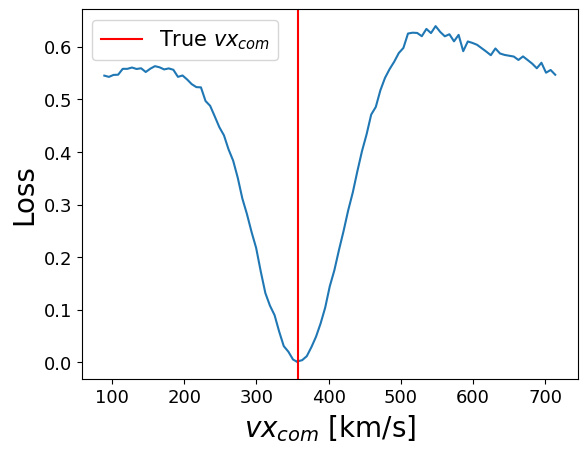

In [18]:
n_sim = 99
keys = jnp.arange(n_sim+1)
vx_com = np.linspace(109.5*(1/4), 109.5*(8/4), n_sim)
# Correct way to append - assign the result back to Mvir
vx_com = np.concatenate([vx_com, np.array([109.5])])  # Append the true vx_com value
vx_com = jnp.array(np.sort(vx_com))
mesh = Mesh(np.array(jax.devices()), ("i",))
vx_com_sharded = jax.device_put(vx_com, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))
# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

@jit
def time_integration_vx_grad_map(vx_com_and_key):
    vx_com, key = vx_com_and_key
    return jax.value_and_grad(time_integration_vx_grad)(vx_com, key)
loss, grad = jax.lax.map(
    time_integration_vx_grad_map, 
    (vx_com_sharded, keys_sharded), 
    batch_size=1
)
plt.figure()
plt.plot(vx_com_sharded*(code_units.code_velocity).to(u.km/u.s), loss)
plt.axvline(109.5*(code_units.code_velocity).to(u.km/u.s), color='r', label='True $vx_{com}$')
plt.xlabel("$vx_{com}$ [km/s]")
plt.ylabel('Loss')
plt.legend()